<a href="https://www.kaggle.com/code/jankrol21/maps-of-walmart-stores?scriptVersionId=134355263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🗺 Walmart Stores Exploration 🗺

In this notebook we will look into the locations of Walmart stores and plot them on a map.

In [1]:
import pandas as pd
import geopandas as gpd

import folium
from folium import plugins
from folium.plugins import HeatMap

from shapely.geometry import Point, box

import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Data Import

In [2]:
walmart_stores_df = pd.read_csv('/kaggle/input/-walmart-stores-location/walmart_store_locaction.csv')
print(walmart_stores_df.shape)
walmart_stores_df.head()

(4654, 22)


,name,url,street_address,city,state,zip_code,country,phone_number_1,phone_number_2,fax_1,...,email_2,website,open_hours,latitude,longitude,facebook,twitter,instagram,pinterest,youtube
0,Conway Supercenter,https://www.walmart.com/store/5/conway-ar/details,1155 Hwy 65 North,Conway,AR,72032,US,501-329-0023,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",35.108660,-92.436905,NaN,NaN,NaN,NaN,NaN
1,Sikeston Supercenter,https://www.walmart.com/store/9/sikeston-mo/de...,1303 S Main St,Sikeston,MO,63801,US,573-472-3020,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",36.857394,-89.586051,NaN,NaN,NaN,NaN,NaN
2,Tahlequah Supercenter,https://www.walmart.com/store/10/tahlequah-ok/...,2020 S Muskogee Ave,Tahlequah,OK,74464,US,918-456-8804,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",35.888765,-94.979859,NaN,NaN,NaN,NaN,NaN
3,Mountain Home Supercenter,https://www.walmart.com/store/11/mountain-home...,65 Wal Mart Dr,Mountain Home,AR,72653,US,870-492-9299,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",36.354957,-92.341026,NaN,NaN,NaN,NaN,NaN
4,Claremore Supercenter,https://www.walmart.com/store/12/claremore-ok/...,1500 S Lynn Riggs Blvd,Claremore,OK,74017,US,918-341-2765,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",36.293955,-95.627125,NaN,NaN,NaN,NaN,NaN


In [3]:
# Non-NaN Columns 
walmart_stores_df.loc[:, walmart_stores_df.isna().sum() != len(walmart_stores_df)].head()

,name,url,street_address,city,state,zip_code,country,phone_number_1,open_hours,latitude,longitude
0,Conway Supercenter,https://www.walmart.com/store/5/conway-ar/details,1155 Hwy 65 North,Conway,AR,72032,US,501-329-0023,"monday - friday : 00:00-24:00, saturday : 00:0...",35.108660,-92.436905
1,Sikeston Supercenter,https://www.walmart.com/store/9/sikeston-mo/de...,1303 S Main St,Sikeston,MO,63801,US,573-472-3020,"monday - friday : 00:00-24:00, saturday : 00:0...",36.857394,-89.586051
2,Tahlequah Supercenter,https://www.walmart.com/store/10/tahlequah-ok/...,2020 S Muskogee Ave,Tahlequah,OK,74464,US,918-456-8804,"monday - friday : 00:00-24:00, saturday : 00:0...",35.888765,-94.979859
3,Mountain Home Supercenter,https://www.walmart.com/store/11/mountain-home...,65 Wal Mart Dr,Mountain Home,AR,72653,US,870-492-9299,"monday - friday : 00:00-24:00, saturday : 00:0...",36.354957,-92.341026
4,Claremore Supercenter,https://www.walmart.com/store/12/claremore-ok/...,1500 S Lynn Riggs Blvd,Claremore,OK,74017,US,918-341-2765,"monday - friday : 00:00-24:00, saturday : 00:0...",36.293955,-95.627125


## How long are the Stores Opened?

In [4]:
walmart_stores_df.open_hours.value_counts().head()

monday - friday : 00:00-24:00, saturday : 00:00-24:00, sunday : 00:00-24:00    2778
monday - friday : 06:00-24:00, saturday : 06:00-24:00, sunday : 06:00-24:00    1152
monday - friday : 06:00-23:00, saturday : 06:00-23:00, sunday : 06:00-23:00     227
monday - friday : 07:00-22:00, saturday : 07:00-22:00, sunday : 07:00-22:00     104
monday - friday : 07:00-24:00, saturday : 07:00-24:00, sunday : 07:00-24:00      81
Name: open_hours, dtype: int64

So it seems that most stores are opened 24/7.

# Transform into Geo Data

Next we transform the pandas DataFrame into a GeoPandas DataFrame using the longitude and latitude coordinate for each store.

In [5]:
# transform into Geo Data Frame
walmart_stores = gpd.GeoDataFrame(
                            walmart_stores_df[['name','state','country']], 
                            geometry=gpd.points_from_xy(walmart_stores_df.longitude, walmart_stores_df.latitude),
                            crs="EPSG:4326")


## Where are the Walmart Stores Located? 

In [6]:
# Shapefile of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

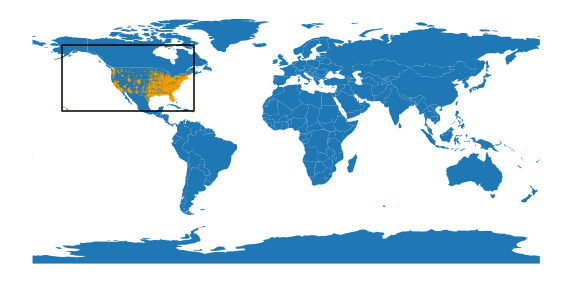

In [7]:
# total bounds for all geometries
stores_location_box = gpd.GeoSeries(box(*walmart_stores.total_bounds))

fig, ax = plt.subplots(figsize=(10, 5))

world.plot(ax = ax)

# plot the store points
walmart_stores.plot(marker='o', color='orange', markersize=0.5, alpha=0.2, ax=ax)
# plot the boundary of store locations
stores_location_box.boundary.plot(color='black', ax=ax)

ax.axis('off')
plt.show()

All Walmart stores are located in the United States, including Alaska and Hawaii and apparently als some locations in Puerto Rico.

## Walmart Stores per State

Next we dive deeper into the store locations across the United States.

In [8]:
stores_per_state = (walmart_stores
                        .groupby('state')
                        .agg({'name':'count'})
                        .rename(columns={'name':'number_stores'})
                        .reset_index()
                        .sort_values('number_stores', ascending=False))

stores_per_state.head()

,state,number_stores
44,TX,508
9,FL,333
4,CA,281
27,NC,192
10,GA,188


### Import US States Shapefile

Downloaded from: https://gadm.org/download_country.html

In [9]:
states = gpd.read_file('../input/us-states-shapefiles/shapefiles/gadm40_USA_1.shp')
states = states.set_crs(epsg=4326)
states.head()

,ID_0,COUNTRY,ID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,USA,United States,USA.1_1,Alabama,AL|Ala.,None,State,State,None,US.AL,None,"MULTIPOLYGON (((-88.12063 30.23321, -88.12122 ..."
1,USA,United States,USA.2_1,Alaska,AK|Alaska,None,State,State,None,US.AK,None,"MULTIPOLYGON (((179.20071 51.35992, 179.20010 ..."
2,USA,United States,USA.3_1,Arizona,AZ|Ariz.,None,State,State,None,US.AZ,None,"POLYGON ((-110.87869 31.33084, -110.97208 31.3..."
3,USA,United States,USA.4_1,Arkansas,AR|Ark.,None,State,State,None,US.AR,None,"POLYGON ((-91.90713 33.00801, -92.01710 33.008..."
4,USA,United States,USA.5_1,California,CA|Calif.,None,State,State,None,US.CA,None,"MULTIPOLYGON (((-117.23300 32.77416, -117.2330..."


As we already have the state names in the data we are going to use them to join the number of Walmart Stores with the geometries of the states. Therefore, no spatial join is needed.

In [10]:
# Take the ISO2 code for each state
states['state'] = states.HASC_1.apply(lambda x: x[-2:])

# add the state geometry to the store counts
stores_per_state = states[['state', 'geometry']].merge(stores_per_state, on='state')

### Use Albers Projection for nicer US Map Plotting

In [11]:
proj_crs_str = """+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"""
stores_per_state = stores_per_state.to_crs(crs=proj_crs_str)

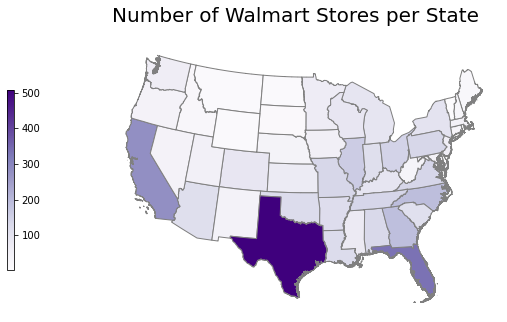

In [12]:
# total bounds for all geometries
cmap='Purples'

outer_states = pd.Series(['PR','AK','HI'])
fig, ax = plt.subplots(figsize=(10, 5))

stores_per_state[~stores_per_state.state.isin(outer_states)].plot(edgecolor='gray', 
                            linewidth=1,
                            column='number_stores', 
                            cmap=cmap,
                            ax=ax)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=stores_per_state.number_stores.min(), vmax=stores_per_state.number_stores.max()), cmap=cmap)
cbaxes = fig.add_axes([0.1, 0.25, 0.01, 0.5])
cbar = fig.colorbar(sm, cax=cbaxes)
fig.suptitle("Number of Walmart Stores per State", fontsize=20)
ax.axis('off')
plt.show()

The most Walmart stores are by far located in Texas. 

Next let's look into the distribution of the exaxt point locations of the stores.

## Heatmap of Store Locations

Inspired by the style of the nightlight images, we look into the distribution of Walmart stores across the United States. Now we can see, that the stores are not mainly clustred around big cities.
Also a clear 

**To create interactive Maps we switch to folium Maps**

By zooming you can also explore the Store locations in Puerto Rico, Hawaii and Alaska.

In [13]:
map_nightlight = folium.Map(location=[40, -95],
                    tiles = "cartodbdark_matter",
                    zoom_start = 4) 

# List of all store coordinates
store_coordinates = [[store_coordinate.y, store_coordinate.x] for store_coordinate in walmart_stores.geometry]

HeatMap(store_coordinates, 
        radius=3, 
        blur=5,
        gradient={0.1: '#d18902', 0.3:'#ffaf03', 0.7: 'white'}).add_to(map_nightlight)

map_nightlight

# Conclusion


I hope you enjoyed this brief plotting example. 

For me it was nice to test out some plotting approaches for geo data and see how easy it is to create interactive maps using folium.
